# A replicate study on using supervised machine learning to detect credit card fraudulent transactions.

This is a walk through on the following research paper analyzing various machinelearning algorithms, such as Logistic Regression (LR), Random Forest (RF), Naïve Bayes (NB) and Multilayer Perceptron (MLP) in order to determine which algorithm is most suitable for credit card fraud detection. 

By replicating the steps from the study, it sought to demonstrate my relevant skills and knowledge on solving the problem. The dataset is enclosed as 'creditcard.csv', which is a [Kaggle dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) containing 284,807 European credit card transactions with 492 fraudulent transactions that occurred over two days in September 2013. 

Varmedja, Dejan, et al. "Credit card fraud detection-machine learning methods." 2019 18th International Symposium INFOTEH-JAHORINA (INFOTEH). IEEE, 2019.

## Exploratory Data Analysis (EDA)

Dataset Context¶
1. The data contains 284,807 European credit card transactions with 492 fraudulent transactions that occurred over two days in September 2013. (Obtained from [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud))
2. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
3. In order to implement a PCA transformation, features need to be previously scaled. So features V1, V2, ... V28 have been scaled already.
4. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
5. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
6. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
7. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, Area Under the Precision-Recall Curve (AUPRC) are recommend to measure the accuracy. Confusion matrix accuracy is not meaningful for unbalanced classification due to this Accuracy Paradox

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

### Distribution of Class, Time and Amount

In [5]:
from collections import Counter
counter = Counter(df['Class'])
print(f'The proportion of fraudulent transactions: {100*counter[1]/len(df):3f}%')

The proportion of fraudulent transactions: 0.172749%


In [6]:
# Time is originally stored as the unit of seconds, therefore divide 60*60 to transform into hour
df['Time'] = df['Time']/(60*60)

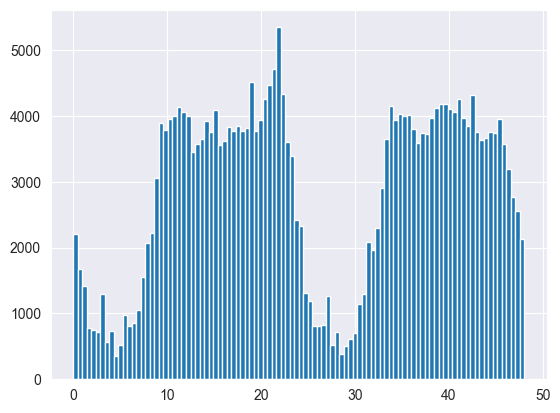

In [7]:
plt.hist(df['Time'], bins=100);

In [8]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

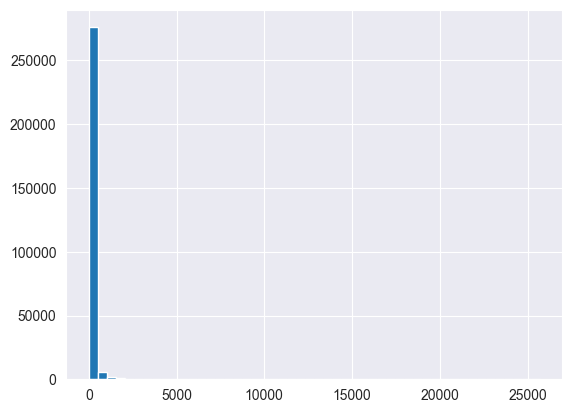

In [9]:
plt.hist(df['Amount'], bins=50);

Notes: 
1. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, Area Under the Precision-Recall Curve (AUPRC) are recommend to measure the accuracy. Confusion matrix accuracy is not meaningful for unbalanced classification due to this Accuracy Paradox.
2. Transaction time concentrates in daytime.
3. Amount is heavily skewed.

## Feature selection

Here, I followed the author's method to deploy the [FeatureSelector](https://github.com/WillKoehrsen/feature-selector) class created by WillKoehrsen to select features to be removed from the  dataset based on the following 5 methods:
1. Find columns with a missing fraction greater than a specified threshold
2. Find features with only a single unique value
3. Find collinear features as identified by a correlation coefficient greater than a specified value
4. Find features with 0.0 importance from a gradient boosting machine
5. Find features that do not contribute to a specified cumulative feature importance from the gradient boosting machine

In [10]:
from feature_selector.feature_selector import FeatureSelector

In [11]:
X = df.drop('Class', axis=1)
y = df['Class']

In [12]:
# Create the instance
fs = FeatureSelector(data = X, labels = y)

1. Missing Values
The first feature selection method is straightforward: find any columns with a missing fraction greater than a specified threshold. For this example we will use a threhold of 0.6 which corresponds to finding features with more than 60% missing values. (This method does not one-hot encode the features first).

In [13]:
fs.identify_missing(missing_threshold=0.6)

0 features with greater than 0.60 missing values.


2. Single Unique Value
The next method is straightforward: find any features that have only a single unique value. (This does not one-hot encode the features).

In [14]:
fs.identify_single_unique()

0 features with a single unique value.


3. Collinear (highly correlated) Features
This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a correlation_threshold.

This method is based on code found at https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

For each pair, the feature that will be removed is the one that comes last in terms of the column ordering in the dataframe. (This method does not one-hot encode the data beforehand unless one_hot=True. Therefore correlations are only calculated between numeric columns)

In [15]:
fs.identify_collinear(correlation_threshold=0.975)

0 features with a correlation magnitude greater than 0.97.


4. Zero Importance Features
This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. The method works by finding feature importances using a gradient boosting machine implemented in the LightGBM library.

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train. The following parameters can be passed to the identify_zero_importance method:

task: either classification or regression. The metric and labels must match with the task
eval_metric: the metric used for early stopping (for example auc for classification or l2 for regression). To see a list of available metrics, refer to the LightGBM docs
n_iterations: number of training runs. The feature importances are averaged over the training runs (default = 10)
early_stopping: whether to use early stopping when training the model (default = True). Early stopping stops training estimators (decision trees) when the performance on a validation set no longer decreases for a specified number of estimators (100 by default in this implementation). Early stopping is a form of regularization used to prevent overfitting to training data
The data is first one-hot encoded for use in the model. This means that some of the zero importance features may be created from one-hot encoding. To view the one-hot encoded columns, we can access the one_hot_features of the FeatureSelector.

Note of caution: in contrast to the other methods, the feature imporances from a model are non-deterministic (have a little randomness). The results of running this method can change each time it is run.

In [16]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.922285	valid_0's binary_logloss: 0.00824923
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

5. Low Importance Features
This method builds off the feature importances from the gradient boosting machine (identify_zero_importance must be run first) by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, if we pass in 0.99, this will find the lowest important features that are not needed to reach 99% of the total feature importance.

When using this method, we must have already run identify_zero_importance and need to pass in a cumulative_importance that accounts for that fraction of total feature importance.

Note of caution: this method builds on the gradient boosting model features importances and again is non-deterministic. I advise running these two methods several times with varying parameters and testing each resulting set of features rather than picking one number and sticking to it.

In [17]:
fs.identify_low_importance(cumulative_importance = 0.99)

29 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.


In [18]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

['V2']

In [19]:
X_removed = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 1 features.


## Resampling with SMOTE

Since we are dealing with imablanced datasets, which is very common in fraud detection task where the fraudulent cases are extremely rare (0.173% in our dataset), it is important to ensure that both training and testing sets contain a representative proportion of fraudulent cases. That allows the model to learn to recognize fraudulent patterns and evaluate its performance effectively.

Therefore, here we apply stratified train-test split alongside a technique called Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class in our dataset.

In [20]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain the ratio of classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_removed, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
counter = Counter(y_train_resampled)
print(counter)

Counter({0: 227451, 1: 227451})


## Train the models with both original and resampled data

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "ANN": MLPClassifier(hidden_layer_sizes=(50, 30, 30, 50), max_iter=500, random_state=42)
    }

    for model_name, model in models.items():
        print(f"\n{model_name} (Original Data):")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
        print(f'Precision: {precision_score(y_test, y_pred):.4f}')
        print(f'Recall: {recall_score(y_test, y_pred):.4f}')
        print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

        print(f"\n{model_name} (Resampled Data):")
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_resampled = model.predict(X_test)
        print(f'Accuracy: {accuracy_score(y_test, y_pred_resampled):.4f}')
        print(f'Precision: {precision_score(y_test, y_pred_resampled):.4f}')
        print(f'Recall: {recall_score(y_test, y_pred_resampled):.4f}')
        print(f'F1 score: {f1_score(y_test, y_pred_resampled):.4f}')

In [24]:
evaluate_models(X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled)


Logistic Regression (Original Data):
Accuracy: 0.9992
Precision: 0.8228
Recall: 0.6633
F1 score: 0.7345

Logistic Regression (Resampled Data):
Accuracy: 0.9823
Precision: 0.0827
Recall: 0.9184
F1 score: 0.1518

Naive Bayes (Original Data):
Accuracy: 0.9773
Precision: 0.0609
Recall: 0.8469
F1 score: 0.1137

Naive Bayes (Resampled Data):
Accuracy: 0.9740
Precision: 0.0552
Recall: 0.8776
F1 score: 0.1039

Random Forest (Original Data):
Accuracy: 0.9996
Precision: 0.9412
Recall: 0.8163
F1 score: 0.8743

Random Forest (Resampled Data):
Accuracy: 0.9996
Precision: 0.8842
Recall: 0.8571
F1 score: 0.8705

ANN (Original Data):
Accuracy: 0.9994
Precision: 0.8667
Recall: 0.7959
F1 score: 0.8298

ANN (Resampled Data):
Accuracy: 0.9989
Precision: 0.6434
Recall: 0.8469
F1 score: 0.7313


To evaluate the performance of different ML models in fraud detection, it involves understanding the trade-offs between different performance metrics and how they relate to your specific problem, especially in the context of imbalanced data.
In the context of fraud detection, recall is often more critical than precision because missing a fraudulent transaction (false negative) can be more costly than investigating a legitimate transaction (false positive). Therefore, if the the cost of false positives (investigating non-fraudulent transactions) is manageable, the model trained with resampled data with higher recall might be preferred to ensure that most fraudulent transactions are detected.

In [25]:
import matplotlib.pyplot as plt

# Storing metrics in a dictionary
results = {
    'Random Forest (Resampled)': {'accuracy': 0.9996, 'precision': 0.8842, 'recall': 0.8571, 'f1_score': 0.8705},
    'Random Forest (Original)': {'accuracy': 0.9996, 'precision': 0.9412, 'recall': 0.8163, 'f1_score': 0.8743},
    'ANN (Original)': {'accuracy': 0.9994, 'precision': 0.8667, 'recall': 0.7959, 'f1_score': 0.8298},
    'ANN (Resampled)': {'accuracy': 0.9989, 'precision': 0.6434, 'recall': 0.8469, 'f1_score': 0.7313},
    'Naive Bayes (Resampled)': {'accuracy': 0.9740, 'precision': 0.0552, 'recall': 0.8776, 'f1_score': 0.1039},
    'Naive Bayes (Original)': {'accuracy': 0.9773, 'precision': 0.0609, 'recall': 0.8469, 'f1_score': 0.1137},
    'Logistic Regression (Resampled)': {'accuracy': 0.9823, 'precision': 0.0827, 'recall': 0.9184, 'f1_score': 0.1518},
    'Logistic Regression (Original)': {'accuracy': 0.9992, 'precision': 0.8228, 'recall': 0.6633, 'f1_score': 0.7345}
}

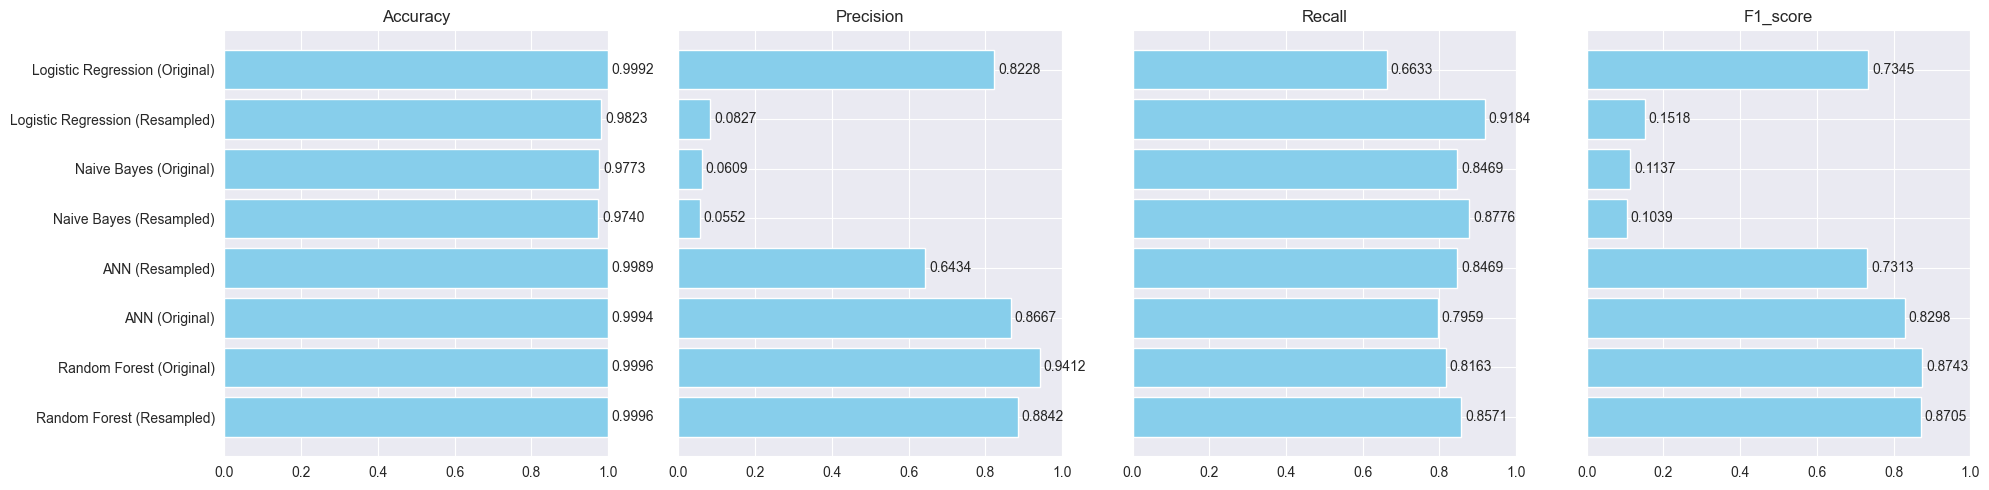

In [26]:
def plot_metrics(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    num_models = len(results)
    model_names = list(results.keys())
    
    # Set up subplots for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
    
    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in model_names]
        axes[i].barh(model_names, values, color='skyblue')
        axes[i].set_title(metric.capitalize())
        axes[i].set_xlim(0, 1)
        for j, v in enumerate(values):
            axes[i].text(v + 0.01, j, f"{v:.4f}", va='center')  # Add text labels
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_metrics(results)

## Conclusion

As a fast growing menace in finance industry, credit card fraud can be detected more effectively by adopting machine learning. In the application supervised learning algorithm in fraud detection, it is important to take the highly skewed datasets into consideration. The presence of significantly more genuine transactions than fraudulent ones (class imbalance) poses a challenge. Specialized techniques like resampling or using class weights are essential to balance the training process.

The reuslts show that 
1. Random Forest trained on resampled data (SMOTE) appears to be the best-performing model for this task, achieving a strong balance between precision, recall, and F1 score without needing resampling. This makes it a practical choice for fraud detection, as it minimizes false positives (high precision) while maintaining a good recall.
2. ANN with original data also performs well and could be a suitable alternative, although it may require further tuning (e.g., different architectures, class weights) to achieve similar robustness as Random Forest.
3. istic Regression could be considered for simpler, smaller datasets but struggles with imbalanced data when resampling is applied.
4. Naive Bayes is not suitable for this type of fraud detection task due to its low precision, which leads to too many false positives.

In summary, Random Forest is likely the best option in this case among these models for detecting fraudulent transactions in an imbalanced dataset, offering strong performance without needing resampling.